In [497]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import pandas as pd
import numpy as np

# Let's look at some data with seasonality + trend

In [498]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

### How does it make sense to structure this data?

In [499]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [500]:
air_passengers = air_passengers.to_period()

In [501]:
air_passengers.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [502]:
air_passengers['1950-06-01':'1950-06-03']

,Passengers
Month,
1950-06,149


### How can we get a sense of this time series?

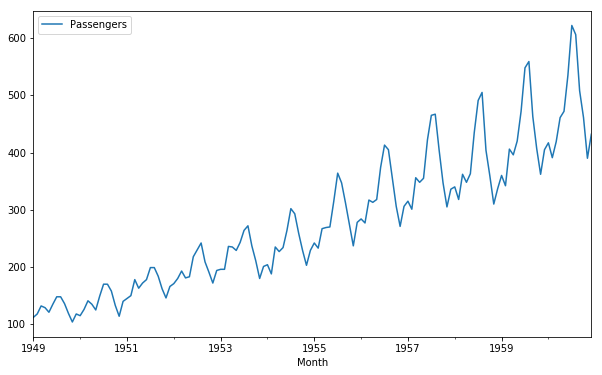

In [503]:
air_passengers.plot()

In [504]:
# first thing we look at for a time series when we want to use common analysis techniques:
# is it stationary: constant mean, constant variance, autocovariance does not depend on time

### Have we got a time independent mean?

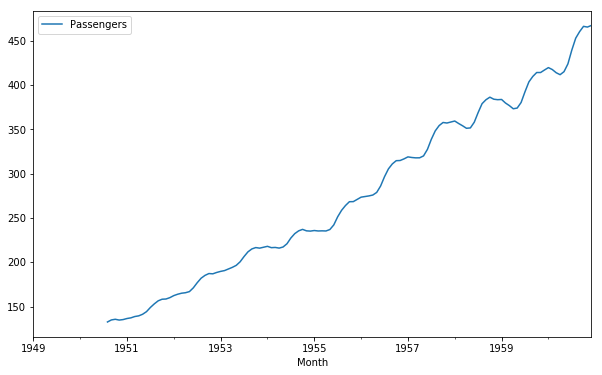

In [505]:
# first test, informally, plot the moving average
air_passengers.rolling(window = 20).mean().plot()

### Have we got a time independent variance?

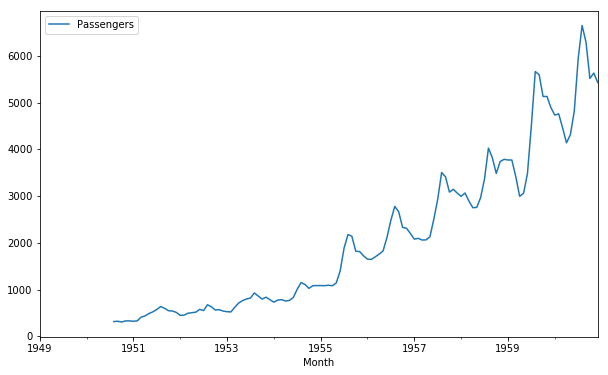

In [506]:
# Can you plot the variance?
air_passengers.rolling(window = 20).var().plot()

### How does sizing your window affect your results?

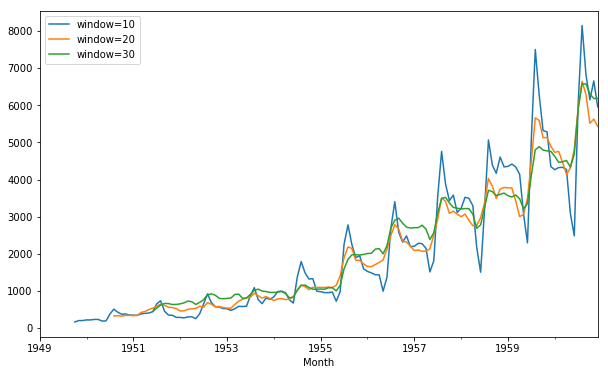

In [507]:
# Can you plot the variance?
ax = air_passengers.rolling(window = 10).var().plot()
air_passengers.rolling(window = 20).var().plot(ax=ax)
air_passengers.rolling(window = 30).var().plot(ax=ax)
ax.legend(['window=10', 'window=20','window=30'])

### How should you size your window?

# More formally testing for stationarity

In [508]:
# next more formally apply the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(air_passengers.Passengers, autolag = 'AIC')

In [509]:
dftest
# What do these numbers mean?

(0.81536887920605061,
 0.99188024343764103,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 996.69293083901903)

### Can we write a function to output these #s sensibly?
Hint: check out statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html

### Are we stuck not doing any analysis now that our time series is not stationary?

Hint: no.
How can we make it stationary?
Why is it non-stationary (2 reasons)

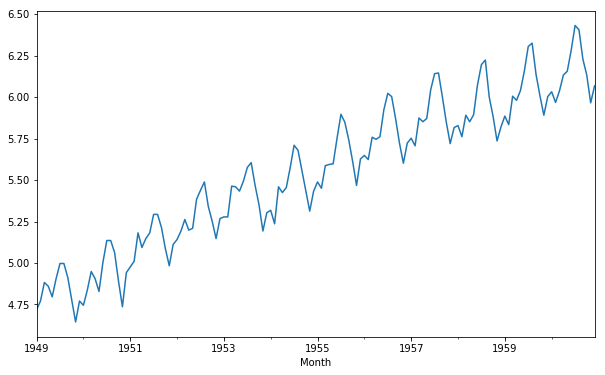

In [510]:
# First let's get rid of the 'trend' contribution to the time series not being stationary
# One method to get rid of a trend is to do a power or log transformation that punishes larger values
# more than smaller values
log_passengers = air_passengers.Passengers.apply(lambda x: np.log(x))
log_passengers.plot()

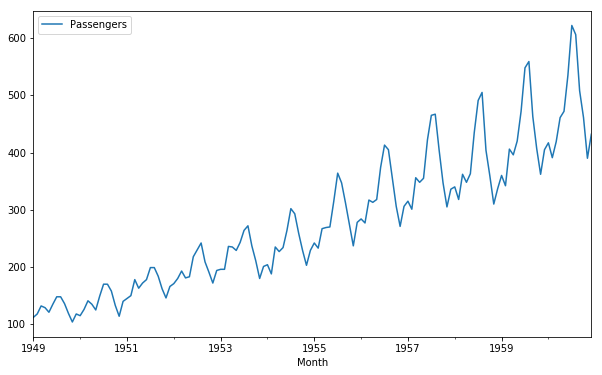

In [511]:
# This reduces the variance in variance as opposed to the original trend
air_passengers.plot()

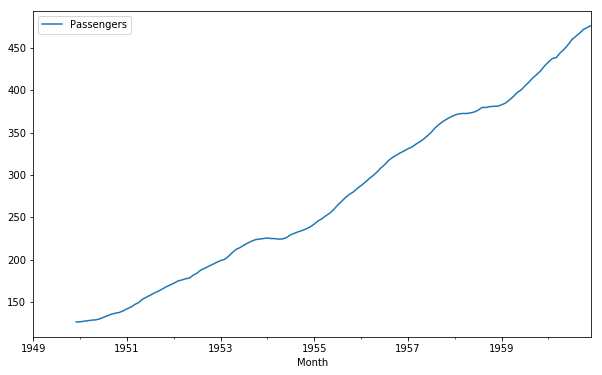

In [512]:
# However there is still a trend we need to remove
# Let's calculate a rolling mean
# Experiment with window size
air_passengers.rolling(window = 12).mean().plot()

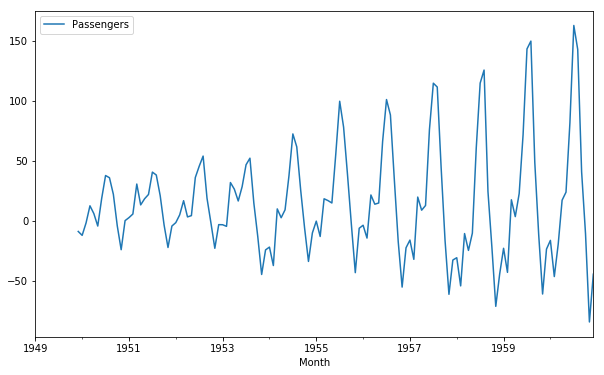

In [513]:
# What if we subtract this rolling mean from the original series?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
passengers_detrended.plot()

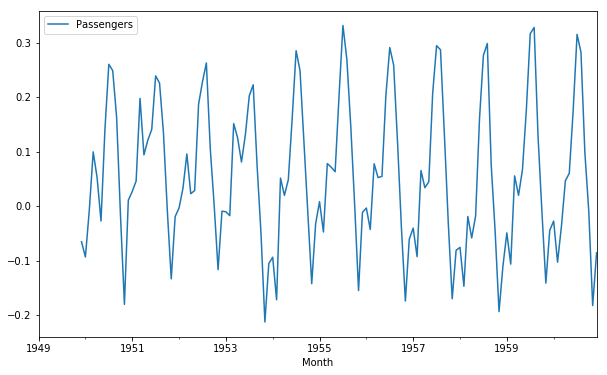

In [514]:
# Exercise: try detrending after taking the log. How does that look?
log_rolling_mean = np.log(air_passengers).rolling(window = 12).mean()
log_passengers_detrended = np.log(air_passengers) - log_rolling_mean
log_passengers_detrended.plot()

In [515]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     3055.
Date:                Thu, 29 Jun 2017   Prob (F-statistic):           2.19e-98
Time:                        15:20:30   Log-Likelihood:                -804.19
No. Observations:                 144   AIC:                             1610.
Df Residuals:                     143   BIC:                             1613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.6012      0.065     55.273      0.000       3.472       3.730
==============================================================================
Omnibus:                       13.493   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.026
Skew:                          -0.264   Prob(JB):                       0.0492
Kurtosis:                       2.148   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

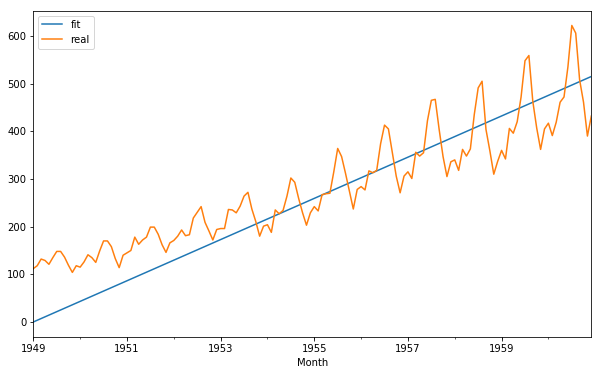

In [516]:
# Now let's use a regression rather than a rolling mean to detrend
from statsmodels.regression.linear_model import OLS
model = OLS(air_passengers.values, list(range(len(air_passengers.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(air_passengers.values)))), index = air_passengers.index)

ax = fit.plot()
air_passengers.plot(ax=ax)
ax.legend(['fit','real'])

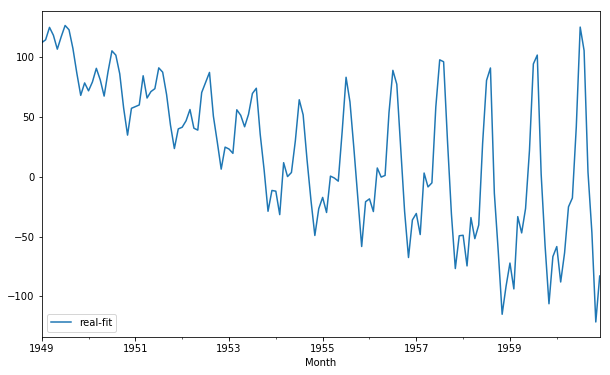

In [517]:
passengers_detrended = air_passengers.Passengers - fit
passengers_detrended.plot(label='real-fit')
plt.legend()

In [518]:
# Now let's take a look at seasonality

In [519]:
# When might a rolling average work better/worse than a regression?

In [520]:
# How might we be able to eliminate both trend and seasonality?
# Looking for two answers...

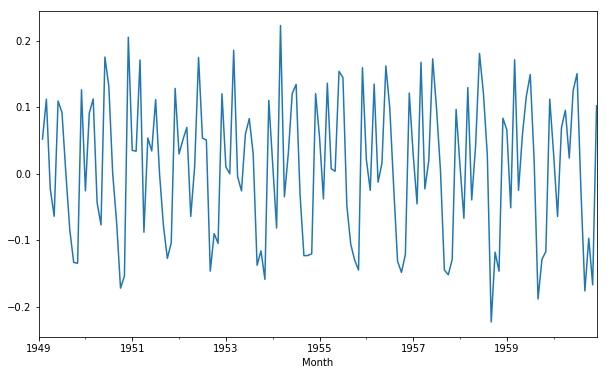

In [521]:
# One common technique is differencing, let's start with log_passengers
log_passengers_diff = log_passengers - log_passengers.shift()
log_passengers_diff.plot()

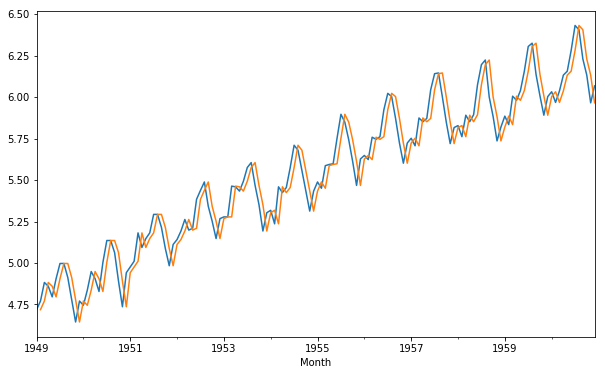

In [522]:
ax = log_passengers.plot()
log_passengers.shift().plot(ax=ax)

In [523]:
# Let's again test for stationarity with a gut level check.
# And let's write a function to do it since this seems like something we'll have to do a lot

In [524]:
from statsmodels.tsa.seasonal import seasonal_decompose

# convert period index to timestamp to feed into seasonal_decompose
log_passengers = log_passengers.to_timestamp()

decomposition = seasonal_decompose(log_passengers)

In [525]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

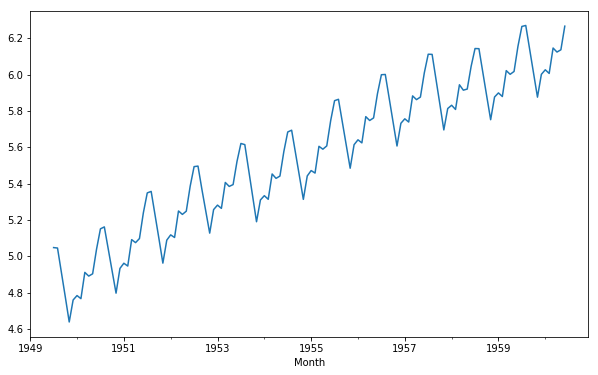

In [526]:
(seasonal+trend).plot()

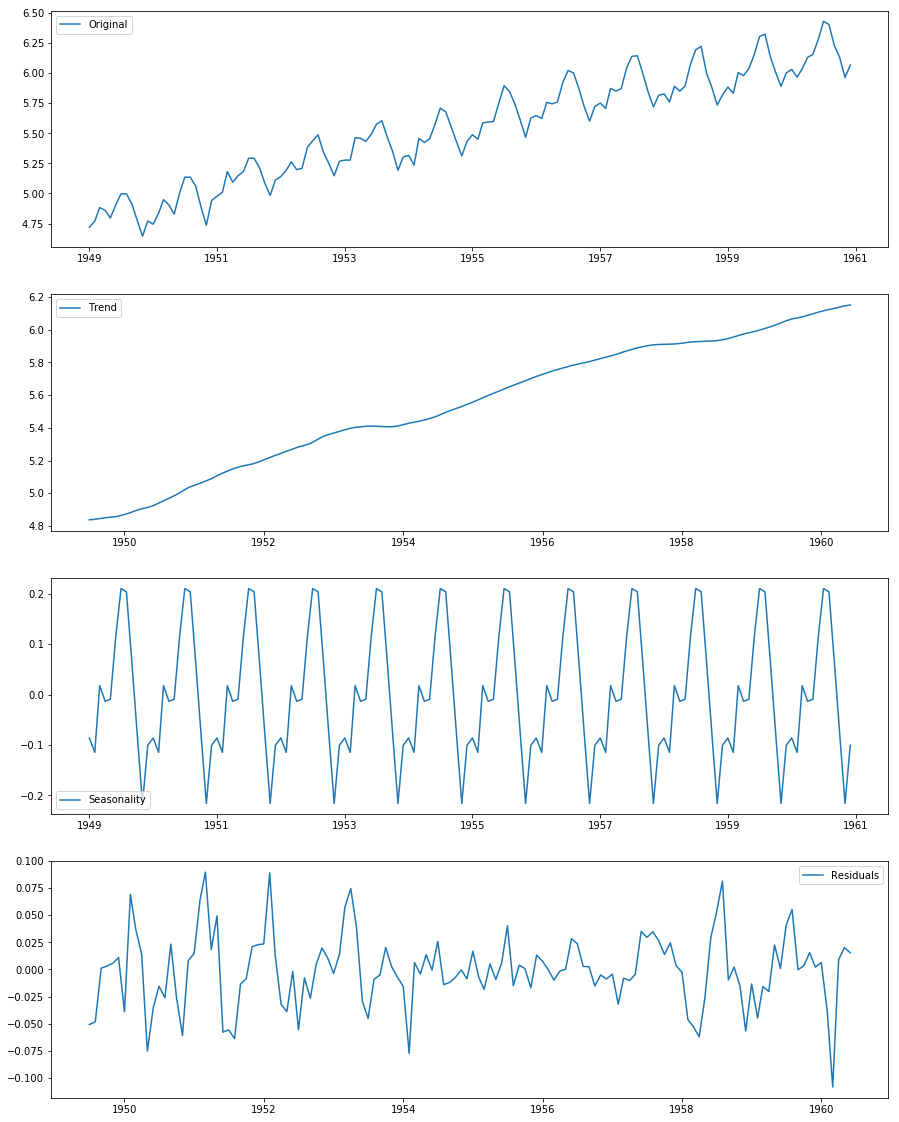

In [527]:
fig, ax = plt.subplots(4,1, figsize=(15,20))

ax[0].plot(log_passengers, label='Original')
ax[0].legend()

ax[1].plot(trend, label='Trend')
ax[1].legend()

ax[2].plot(seasonal,label='Seasonality')
ax[2].legend()

ax[3].plot(residual, label='Residuals')
ax[3].legend()

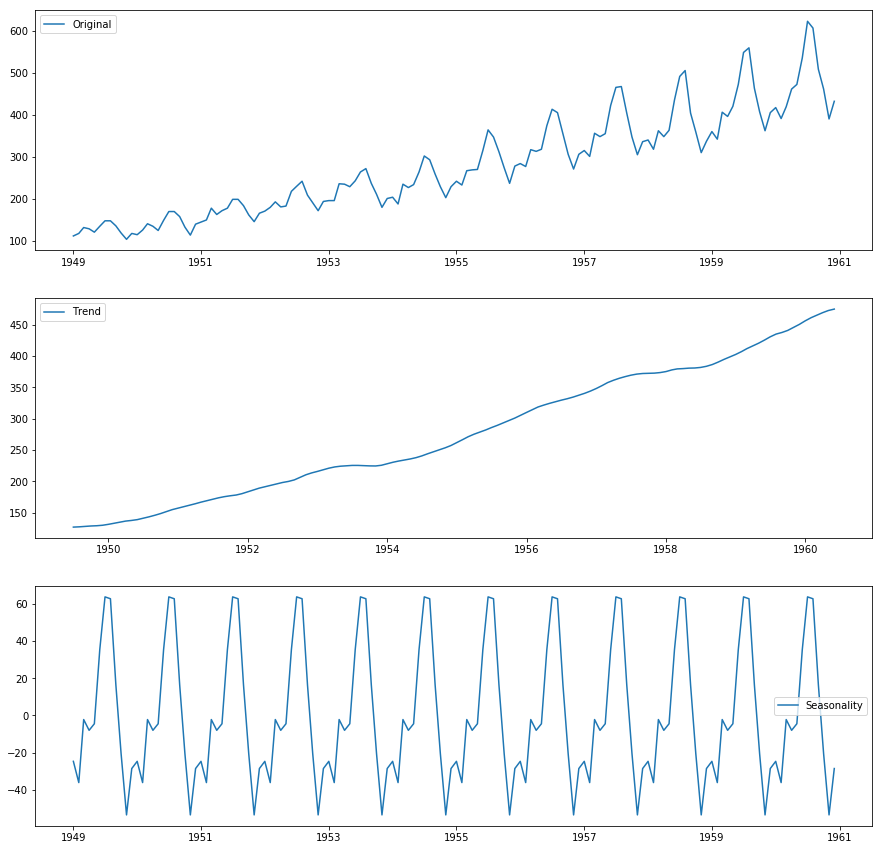

In [528]:
# try with non-log data
air_passengers = air_passengers.to_timestamp()
decomposition = seasonal_decompose(air_passengers)

fig, ax = plt.subplots(3,1, figsize=(15,15))

ax[0].plot(air_passengers, label='Original')
ax[0].legend()

ax[1].plot(decomposition.trend, label='Trend')
ax[1].legend()

ax[2].plot(decomposition.seasonal,label='Seasonality')
ax[2].legend()

# ax[3].plot(decomposition.residual, label='Residuals')
# ax[3].legend()

# How OLS works: from [http://www.statsmodels.org/dev/regression.html]

In [529]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [530]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

In [531]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

In [532]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.404e+06
Date:                Thu, 29 Jun 2017   Prob (F-statistic):          1.67e-245
Time:                        15:20:32   Log-Likelihood:                -131.72
No. Observations:                 100   AIC:                             269.4
Df Residuals:                      97   BIC:                             277.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9650      0.270      3.578      0.0